<a href="https://colab.research.google.com/github/vignesh-0510/SolarFlareExplainableWindowDetection/blob/main/phase_1_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import tqdm
import pickle

In [ ]:
def extract_start_end_time(filename):
  """Extracts start and end time from a filename string.

  Args:
    filename: The filename string in the format
      'FQ_ar146_s2010-08-29T17:12:00_e2010-08-30T05:00:00.csv'.

  Returns:
    A tuple containing the start time and end time strings, or None if the
    filename does not match the expected format.
  """
  try:
    parts = filename.split('_')
    start_time_part = parts[2][1:]  # Remove 's' prefix
    end_time_part = parts[3][1:]   # Remove 'e' prefix
    return start_time_part, end_time_part
  except IndexError:
    return None, None

def min_max_scaling(data, min_val, max_val):
  norm_data = (data - min_val) / (max_val - min_val)
  return norm_data

def process_file(filepath, included_columns, meta_dict, frequency_modes= 10, normalized= True):
  modes = frequency_modes // 2
  df = pd.read_csv(filepath, sep='\t', usecols=included_columns)
  data_dict = {}
  for col in included_columns:
    y = df[col].values
    if normalized:
      y = min_max_scaling(y, meta_dict[col]['min'], meta_dict[col]['max'])
    y_f = torch.fft.rfft(torch.tensor(y))
    y_f = torch.cat((y_f[:modes], y_f[-modes:]))
    data_dict[col] = y_f.numpy()
  return data_dict

In [ ]:
!wget https://www.dropbox.com/scl/fi/kmbx0skl79yk3ywk3jfkq/partition4_instances.tar.gz?rlkey=sx3lijmh7foyzy736hfym87cs&st=1gtxbj90&dl=0
!tar -xzvf /content/partition4_instances.tar.gz?rlkey=sx3lijmh7foyzy736hfym87cs&st=1gtxbj90

Streaming output truncated to the last 5000 lines.
partition4/NF/FQ_ar4422_s2014-08-06T05:36:00_e2014-08-06T17:24:00.csv
partition4/NF/FQ_ar4998_s2014-12-30T11:24:00_e2014-12-30T23:12:00.csv
partition4/NF/FQ_ar4955_s2014-12-24T16:24:00_e2014-12-25T04:12:00.csv
partition4/NF/FQ_ar4724_s2014-10-26T09:24:00_e2014-10-26T21:12:00.csv
partition4/NF/FQ_ar5198_s2015-02-12T22:36:00_e2015-02-13T10:24:00.csv
partition4/NF/FQ_ar4718_s2014-10-29T04:36:00_e2014-10-29T16:24:00.csv
partition4/NF/FQ_ar4527_s2014-09-02T12:48:00_e2014-09-03T00:36:00.csv
partition4/NF/C3.7@9568:Primary_ar4941_s2014-12-23T03:00:00_e2014-12-23T14:48:00.csv
partition4/NF/FQ_ar4469_s2014-08-21T00:48:00_e2014-08-21T12:36:00.csv
partition4/NF/FQ_ar5125_s2015-01-30T00:24:00_e2015-01-30T12:12:00.csv
partition4/NF/FQ_ar4421_s2014-08-03T15:12:00_e2014-08-04T03:00:00.csv
partition4/NF/FQ_ar4228_s2014-06-20T04:24:00_e2014-06-20T16:12:00.csv
partition4/NF/FQ_ar5225_s2015-02-20T19:24:00_e2015-02-21T07:12:00.csv
partition4/NF/C6.7@9274:

In [ ]:
included_columns = ['TOTUSJH', 'TOTBSQ', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH', 'SAVNCPP', 'USFLUX', 'TOTFZ',
                    'MEANPOT', 'EPSZ', 'MEANSHR', 'SHRGT45', 'MEANGAM', 'MEANGBT', 'MEANGBZ', 'MEANGBH',
                    'MEANJZH', 'TOTFY','MEANJZD', 'MEANALP', 'TOTFX', 'EPSY', 'EPSX', 'R_VALUE', 'CRVAL1',
                    'CRLN_OBS', 'CRLT_OBS', 'CRVAL2', 'HC_ANGLE','XR_MAX']

In [ ]:
included_columns = ['TOTUSJH', 'TOTPOT', 'TOTUSJZ']
partition_number = 4

In [ ]:
BASE_DIR = f'/content/partition{partition_number}'
meta_dict = {}
min_val = {}
max_val = {}
for classes in os.listdir(BASE_DIR):
  for filenames in tqdm.tqdm(os.listdir(os.path.join(BASE_DIR, classes))):
    for col in included_columns:
      df = pd.read_csv(os.path.join(BASE_DIR, classes, filenames), sep='\t', usecols=included_columns)
      if col not in min_val or min_val[col] is None or df[col].min() < min_val[col]:
        min_val[col] = df[col].min()
      if col not in max_val or max_val[col] is None or df[col].max() > max_val[col]:
        max_val[col] = df[col].max()

for col in included_columns:
  meta_dict[col] = {}
  meta_dict[col]['min'] = min_val[col]
  meta_dict[col]['max'] = max_val[col]

100%|██████████| 50096/50096 [05:32<00:00, 150.61it/s]


In [ ]:
with open(f'swan-sf-partition{partition_number}-metadata.pkl', 'wb') as f:
    pickle.dump(meta_dict, f)

In [ ]:
BASE_DIR = f'/content/partition{partition_number}'
df_dict = {}
idx = 1
for classes in os.listdir(BASE_DIR):
  for filenames in tqdm.tqdm(os.listdir(os.path.join(BASE_DIR, classes))):
    file_dict = {}
    file_dict['class'] = classes
    filename = os.path.basename(filenames).split('.csv')[0]
    file_dict['filename'] = filename
    category = ''
    if filename[:2] == 'FQ':
      category = 'FQ'
      sub_category = 'NA'
    else:
      category = filename[0]
      sub_category = filename.split('@')[0][1:]
    file_dict['category'] = category
    file_dict['sub_category'] = sub_category
    start_time, end_time = extract_start_end_time(filename)
    file_dict['start_time'] = start_time
    file_dict['end_time'] = end_time
    file_dict.update(process_file(os.path.join(BASE_DIR, classes, filenames), included_columns, meta_dict, frequency_modes=10, normalized=True))
    df_dict[idx] = file_dict
    idx+=1


100%|██████████| 50096/50096 [01:56<00:00, 431.34it/s]


In [ ]:
f_df = pd.DataFrame.from_dict(df_dict, orient='index')
f_df.reset_index(inplace=True)

In [ ]:
f_df.to_csv(f'swan-sf-partition{partition_number}-normalized.csv', index=False)
f_df[f_df['class'] == 'FL'].head()

,index,class,filename,category,sub_category,start_time,end_time,TOTUSJH,TOTPOT,TOTUSJZ
0,1,FL,M1.0@9551:Primary_ar4941_s2014-12-20T20:00:00_...,M,1.0,2014-12-20T20:00:00,2014-12-21T07:48:00,"[(3.809663348135969+0j), (-0.00668143402259648...","[(0.3021512459709389+0j), (-0.0002976445092113...","[(2.880401208172674+0j), (0.002870140514556647..."
1,2,FL,M1.3@9633:Primary_ar5011_s2015-01-03T05:36:00_...,M,1.3,2015-01-03T05:36:00,2015-01-03T17:24:00,"[(5.49866609908033+0j), (0.057430153976607154-...","[(0.38299753755445726+0j), (-7.195554744209498...","[(4.172058346419545+0j), (-0.01553303856040872..."
2,3,FL,M2.2@9053:Secondary_ar4678_s2014-10-14T00:12:0...,M,2.2,2014-10-14T00:12:00,2014-10-14T12:00:00,"[(1.7739106059981875+0j), (-0.0387819561505605...","[(0.09847772098034148+0j), (-0.000827955363456...","[(1.312543750997279+0j), (-0.04555072330092116..."
3,4,FL,M1.1@8886:Primary_ar4530_s2014-09-05T15:36:00_...,M,1.1,2014-09-05T15:36:00,2014-09-06T03:24:00,"[(6.002818535482941+0j), (-0.07506186622998333...","[(0.34194330746503326+0j), (-0.000831404094364...","[(3.729595724674258+0j), (-0.02611563895513016..."
4,5,FL,M1.1@9625:Primary_ar5011_s2015-01-02T01:36:00_...,M,1.1,2015-01-02T01:36:00,2015-01-02T13:24:00,"[(5.405508681642305+0j), (0.00930627925773748+...","[(0.3402546994532393+0j), (0.00255777684277595...","[(4.212493689122564+0j), (0.011764496309767843..."


In [ ]:
df = pd.read_csv('/content/swan-sf-data.csv')
df[df['class']=='FL'].head()

In [ ]:
# prompt: save the swan-sf data to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Copy the CSV file to your Google Drive
!cp /content/swan-sf-partition4-normalized.csv /content/drive/MyDrive/ADM/partition4/swan-sf-partition4-normalized.csv

# Copy the pickle file to your Google Drive
!cp /content/swan-sf-partition4-metadata.pkl /content/drive/MyDrive/ADM/partition4/swan-sf-metadata.pkl

# Extract Interacting important features

In [ ]:
# Copy the CSV file to your Google Drive
!cp /content/drive/MyDrive/ADM/swan-sf-data.csv /content/swan-sf-data.csv

# Copy the pickle file to your Google Drive
!cp /content/drive/MyDrive/ADM/swan-sf-metadata.pkl /content/swan-sf-metadata.pkl

In [ ]:
metadata_columns = ['index', 'class',	'filename',	'category',	'sub_category',	'start_time',	'end_time']
interacting_columns = included_columns

In [ ]:
partition_number = 3
df = pd.read_csv(f'/content/swan-sf-partition{partition_number}-normalized.csv', usecols=metadata_columns + interacting_columns, index_col='index')

In [ ]:
df

,class,filename,category,sub_category,start_time,end_time,TOTUSJH,TOTPOT,TOTUSJZ
index,,,,,,,,,
1,FL,M1.6@7658:Primary_ar3721_s2014-02-13T20:24:00_...,M,1.6,2014-02-13T20:24:00,2014-02-14T08:12:00,[ 2.76008366e+01+0.j -1.58150815e-01+0...,[ 7.68703122e-02+0.00000000e+00j 2.11459814e-...,[ 3.62409630e+01+0.j -2.91961305e-01+0...
2,FL,M6.6@7520:Primary_ar3686_s2014-01-29T20:00:00_...,M,6.6,2014-01-29T20:00:00,2014-01-30T07:48:00,[ 4.31665406e+01+0.j -6.55648902e-01+0...,[ 1.58046787e-01+0.00000000e+00j -1.65578066e-...,[ 4.48133319e+01+0.j -3.18526917e-01+0...
3,FL,M7.2@7396:Primary_ar3563_s2014-01-06T02:00:00_...,M,7.2,2014-01-06T02:00:00,2014-01-06T13:48:00,[ 3.96368060e+01+0.j -6.51385715e-01-0...,[ 2.05900181e-01+0.00000000e+00j -4.47234847e-...,[ 5.54934185e+01+0.j -1.58298064e-01+0...
4,FL,M1.4@8370:Primary_ar4197_s2014-06-05T23:24:00_...,M,1.4,2014-06-05T23:24:00,2014-06-06T11:12:00,[ 1.04983045e+01+0.j -8.66760460e-02+0...,[ 2.17764034e-02+0.00000000e+00j 3.39245579e-...,[ 1.54850267e+01+0.j 6.85109186e-02+0...
5,FL,M1.3@8353:Primary_ar4186_s2014-06-02T01:24:00_...,M,1.3,2014-06-02T01:24:00,2014-06-02T13:12:00,[ 4.17216994e+00+0.j 4.03328455e-04-0...,[ 1.00392920e-02+0.00000000e+00j 1.30465858e-...,[ 6.46291882e+00+0.j 5.38898373e-02+0...
...,...,...,...,...,...,...,...,...,...
42506,NF,FQ_ar3985_s2014-04-13T04:24:00_e2014-04-13T16:...,FQ,NaN,2014-04-13T04:24:00,2014-04-13T16:12:00,[ 4.01777895e+00+0.j 1.59608403e-02-0...,[ 2.75187355e-02+0.00000000e+00j -1.30592533e-...,[ 6.66614795e+00+0.j -4.36643672e-02-0...
42507,NF,FQ_ar3604_s2014-01-10T03:12:00_e2014-01-10T15:...,FQ,NaN,2014-01-10T03:12:00,2014-01-10T15:00:00,[ 2.72031110e+00+0.j 4.19473086e-02-0...,[ 3.23559745e-03+0.00000000e+00j -2.66153570e-...,[ 3.76182747e+00+0.j -4.18107045e-02+0...
42508,NF,FQ_ar3601_s2014-01-11T06:24:00_e2014-01-11T18:...,FQ,NaN,2014-01-11T06:24:00,2014-01-11T18:12:00,[ 5.15591104e+00+0.j -3.15842869e-02+0...,[ 2.04219244e-02+0.00000000e+00j 1.31641655e-...,[ 7.79228680e+00+0.j 3.70143307e-03+0...


In [ ]:
def expand_complex_vectors(df, interacting_columns):
  """
  Extracts real parts of complex vectors in specified columns and expands them.

  Args:
    df: The pandas DataFrame.
    interacting_columns: A list of column names containing complex vectors.

  Returns:
    A new DataFrame with expanded real parts of the vectors.
  """

  new_df = df.copy()
  for col in interacting_columns:
      # Assuming each cell in the column is a string representation of a complex vector
      # Convert string to complex numpy array
      new_df[col] = new_df[col].apply(lambda x: np.fromstring(x[1:-1], dtype=complex, sep=' '))
      # Extract real part
      real_parts = new_df[col].apply(lambda x: np.real(x))
      # Create new columns for each dimension
      for i in range(10):  # Assuming each vector has 10 dimensions
          new_column_name = f"{col}_real_{i}"
          new_df[new_column_name] = real_parts.apply(lambda x: x[i] if len(x) > i else np.nan)
      # Drop the original column containing the complex vector
      new_df.drop(col, axis=1, inplace=True)

  return new_df

# Apply the function to your DataFrame
new_df = expand_complex_vectors(df, interacting_columns)


In [ ]:
new_df.to_csv(f'/content/swan_sf_partition{partition_number}_interacting_features_normalized.csv', index=False)

In [ ]:
new_df.head()

,class,filename,category,sub_category,start_time,end_time,TOTUSJH_real_0,TOTUSJH_real_1,TOTUSJH_real_2,TOTUSJH_real_3,...,TOTUSJZ_real_0,TOTUSJZ_real_1,TOTUSJZ_real_2,TOTUSJZ_real_3,TOTUSJZ_real_4,TOTUSJZ_real_5,TOTUSJZ_real_6,TOTUSJZ_real_7,TOTUSJZ_real_8,TOTUSJZ_real_9
index,,,,,,,,,,,,,,,,,,,,,
1,FL,M2.2@1189:Secondary_ar377_s2011-02-13T10:00:00...,M,2.2,2011-02-13T10:00:00,2011-02-13T21:48:00,25.655668,-0.266721,-0.349868,-0.111726,...,14.435770,-0.090167,-0.153723,-0.069948,-0.036591,-0.017413,-0.004810,-0.012120,-0.020515,-0.033489
2,FL,X5.4@3386:Primary_ar1449_s2012-03-05T17:24:00_...,X,5.4,2012-03-05T17:24:00,2012-03-06T05:12:00,49.294859,-0.262091,-0.023754,0.033315,...,24.474292,-0.020417,0.004244,0.075554,0.050745,-0.034937,-0.027501,-0.014023,-0.027082,-0.031088
3,FL,M1.0@1534:Primary_ar437_s2011-03-24T12:48:00_e...,M,1.0,2011-03-24T12:48:00,2011-03-25T00:36:00,29.948976,-0.095578,-0.292707,0.173093,...,20.141067,-0.127997,-0.317684,0.230800,-0.083261,-0.037864,0.000000,-0.032875,-0.032793,-0.042208
4,FL,M1.3@2574:Primary_ar892_s2011-10-01T16:36:00_e...,M,1.3,2011-10-01T16:36:00,2011-10-02T04:24:00,27.327002,0.008696,-0.041243,-0.081613,...,17.157539,-0.106706,-0.198092,-0.177431,-0.006786,0.006161,-0.006330,0.019713,0.003779,0.023925
5,FL,M2.5@1892:Primary_ar637_s2011-06-06T00:24:00_e...,M,2.5,2011-06-06T00:24:00,2011-06-06T12:12:00,15.095336,-0.090054,0.012144,0.073545,...,9.941799,-0.115310,0.063442,0.041456,-0.019403,0.008809,0.012305,0.018596,-0.000717,0.017201


In [ ]:
!cp /content/swan_sf_partition4_interacting_features_normalized.csv /content/drive/MyDrive/ADM/partition4/swan_sf_partition4_interacting_features_normalized.csv

In [ ]:
with open('/content/swan-sf-metadata.pkl', 'rb') as f:
    meta_dict = pickle.load(f)

In [ ]:
meta_dict

{'TOTUSJH': {'min': 24.14147449792293, 'max': 30.535328185485486},
 'TOTPOT': {'min': 24.14147449792293, 'max': 2.046287674141772e+21},
 'TOTUSJZ': {'min': 24.14147449792293, 'max': 2.046287674141772e+21}}

In [ ]:
BASE_DIR = '/content/partition1'
hist_dict = {}
for classes in os.listdir(BASE_DIR):
  hist_dict[classes] = {}
  for filenames in tqdm.tqdm(os.listdir(os.path.join(BASE_DIR, classes))):
    df = pd.read_csv(os.path.join(BASE_DIR, classes, filenames), sep='\t', usecols=included_columns)
    for col in included_columns:
      if col not in hist_dict[classes]:
        hist_dict[classes][col] = []
      hist_dict[classes][col].extend(df[col].values)

100%|██████████| 2/2 [02:35<00:00, 77.92s/it]


In [ ]:
hist_dict['FL'].keys()

dict_keys(['TOTUSJH', 'TOTPOT', 'TOTUSJZ'])

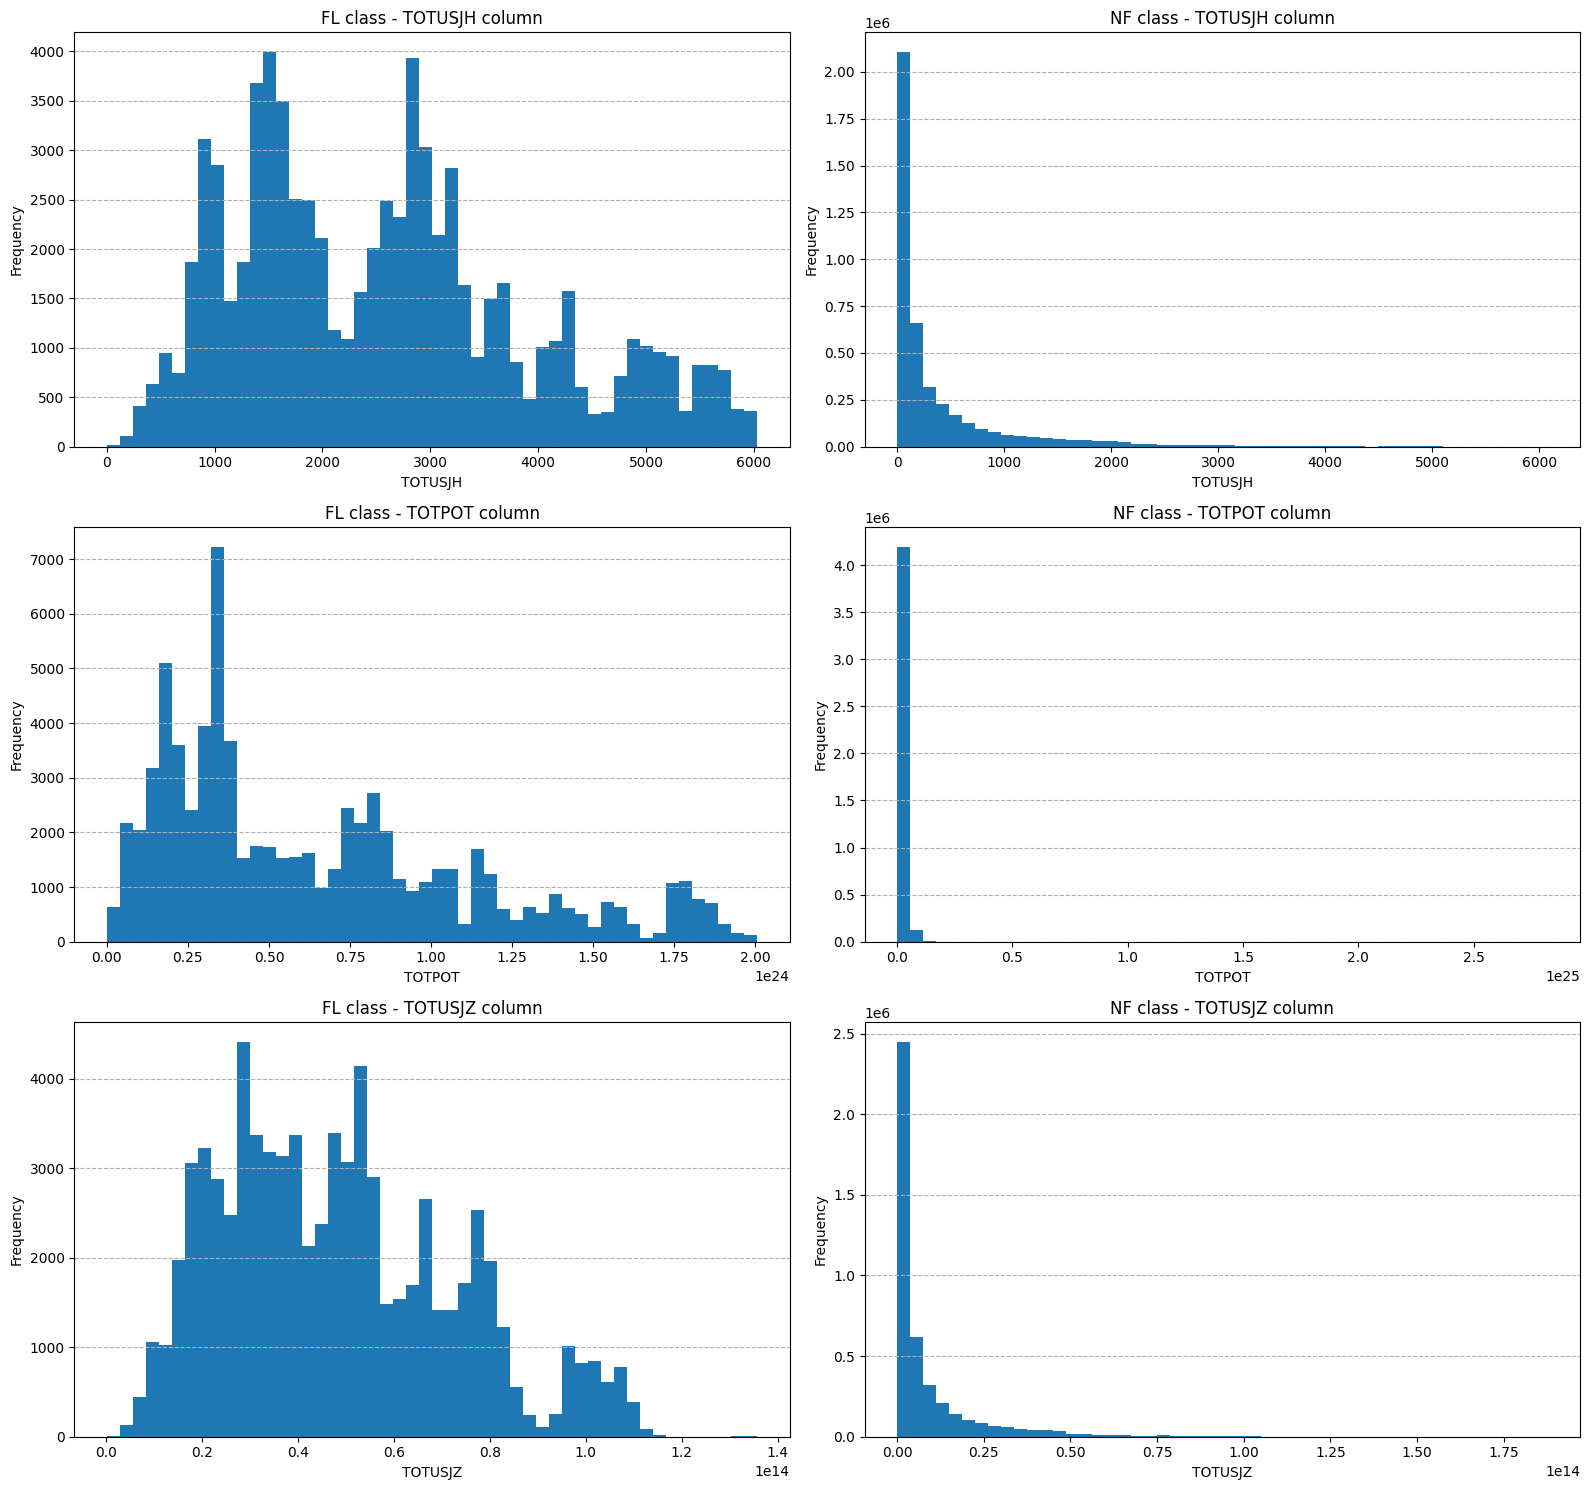

In [ ]:
num_rows = 3
num_cols = 2  # Number of columns in hist_dict

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 15)) # Adjust figsize as needed

for i, (classes, val) in enumerate(hist_dict.items()):
    for j, (col, col_data) in enumerate(val.items()):
      ax = axes[j , i]
      ax.hist(col_data, bins=50)  # Adjust number of bins as needed
      ax.set_title(f'{classes} class - {col} column')
      ax.set_xlabel(col)
      ax.grid(True, axis='y', linestyle='--')
      ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:
meta_dict

{'TOTUSJH': {'min': 0.0, 'max': 6078.23759924654},
 'TOTPOT': {'min': 0.0, 'max': 2.820688751045556e+25},
 'TOTUSJZ': {'min': 0.0, 'max': 187665592928940.44}}